## Training augmanted data

### In this notebook I have made some images augmantation tequeniques to see if the preformance of the model would be better or not. And I have used the same model architecture, the same loss function and the same evaluation method.

In [1]:
! pip install --user torch torchvision matplotlib numpy progressbar

  Preparing metadata (setup.py) ... - done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=353a14b923015ab29a5f5fb58a53ba5093785493b49c93cc3a1906938dd01706
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [2]:
! pip install monai

     |████████████████████████████████| 721 kB 891 kB/s            


In [3]:
import numpy as np 
import pandas as pd 
import os

import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm
import monai

In [4]:
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE = 16
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

## Downloading Dataset
In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data

In [5]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

download_data()

downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip


100% |########################################################################|


In [6]:
class JawsDataset(torch.utils.data.Dataset):
    def __init__(self, dicom_file_list, transforms):
        self.dicom_file_list = dicom_file_list
        self.transforms = transforms

    def __len__(self):
        return len(self.dicom_file_list)

    def __getitem__(self, idx):
        dicom_path = self.dicom_file_list[idx]
        label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
        dicom_file = gzip.GzipFile(dicom_path, 'rb')
        dicom = np.load(dicom_file)
        label_file = gzip.GzipFile(label_path, 'rb')
        label = np.load(label_file)
        return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
    files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:], transforms),
            JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
    files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:], transforms),
            JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
    files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:], transforms),
            JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
    files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
    files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
    files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, transforms)


In [7]:
IMAGE_HEIGHT = 160  
IMAGE_WIDTH = 240  

In [8]:
augment = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
            transforms.CenterCrop((IMAGE_HEIGHT//2, IMAGE_WIDTH//2)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.Normalize(mean=0, std=1)
            ])

In [9]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(augment)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(augment)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(augment)

print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')

axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice
coronal training dataset: 7277 slice
sagittal training dataset: 7277 slice


In [10]:
print(f'axial validatiaon dataset: {len(axial_validatiaon_dataset)} slice')
print(f'coronal validatiaon dataset: {len(coronal_validation_dataset)} slice')
print(f'sagittal validatiaon dataset: {len(sagittal_validation_dataset)} slice')

axial_validatiaon_loader = torch.utils.data.DataLoader(axial_validatiaon_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_validatiaon_loader = torch.utils.data.DataLoader(coronal_validation_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_validatiaon_loader = torch.utils.data.DataLoader(sagittal_validation_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial validatiaon dataset: 561 slice
coronal validatiaon dataset: 809 slice
sagittal validatiaon dataset: 809 slice


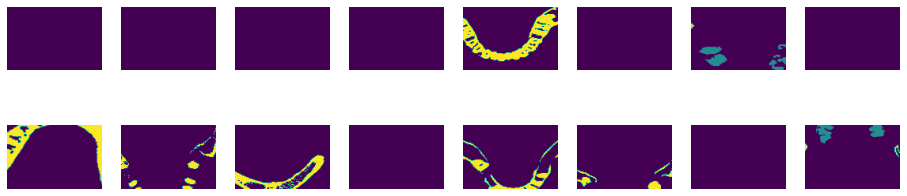

In [11]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
    plt.subplot(2, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='bone')
    plt.imshow(labels[index].numpy().squeeze())

## Training
Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(DoubleConv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNET(nn.Module):
    def __init__(
            self, input_channel=3, output_channel=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(input_channel, feature))
            input_channel = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], output_channel, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [14]:
def save_checkpoint(state, filename="model_checkpoint.pth.tar"):
    print("Saving checkpoint")
    torch.save(state, filename)

In [15]:
def load_checkpoint(checkpoint, model):
    print("Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.01):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.flatten()
        targets = targets.flatten()
        
        intersection = np.sum(inputs * targets)                        
        dice = (2.*intersection + smooth)/(np.sum(inputs) + np.sum(targets) + smooth)
        
        return 1 - dice

In [17]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            
            # a threshold for pixels predicted object 1 / background 0
            t = .5 
            preds = (preds > t).float()
            
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [18]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    
    for batch_idx, (images, labels) in enumerate(loop):
        images = images.to(device=DEVICE)
        labels = labels.to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    

In [19]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
LOAD_MODEL = False
loss_values = []
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
def train_model_2d(train_loaders, val_loaders):
    model = UNET(input_channel=1, output_channel=1).to(DEVICE)
    train_loader = train_loaders
    val_loader = val_loaders
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = monai.losses.DiceLoss(sigmoid=True)
    scaler = torch.cuda.amp.GradScaler()
    
    
    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        
        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        
        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)
    
    return model

In [21]:
def predict(data_loader):
    # Tests

    for i in range(5):
        with torch.no_grad():
            for images ,masks in data_loader :
                images = images.to(DEVICE)
                masks  = masks.to(DEVICE)

                mask_pred = axial_model(images)

                img = mask_pred.cuda()
                masks = masks.cuda()
                masks_2 = (masks > 0.5)
            
                loss_fn = monai.losses.DiceLoss(sigmoid=True)
                loss = loss_fn(mask_pred, masks)
                print("loss prediction: ", float(loss))
            
                img = mask_pred.cpu().numpy()
                masks = masks.cpu().numpy()
                masks_2 = (masks > 0.5).astype(int)
            
                fig, axes = plt.subplots(1, 3, figsize=(15, 15))

                axes[0].imshow(masks[0][0])
                axes[0].set_title('Ground Truth Mask')

                axes[1].imshow(img[0][0])
                axes[1].set_title('Probabilistic Mask')
            
                axes[2].imshow(masks_2[0][0])
                axes[2].set_title('Probabilistic Mask threshold')
            
                break

## Train a model for each view

In [22]:
axial_model = train_model_2d(axial_train_loader, axial_validatiaon_loader)

100%|██████████| 36/36 [00:06<00:00,  5.15it/s]


Dice score: 0.20532675087451935


100%|██████████| 36/36 [00:06<00:00,  5.53it/s]


Dice score: 0.23668789863586426


100%|██████████| 36/36 [00:06<00:00,  5.56it/s]


Dice score: 0.25108373165130615


100%|██████████| 36/36 [00:06<00:00,  5.45it/s]


Dice score: 0.37354838848114014


100%|██████████| 36/36 [00:06<00:00,  5.56it/s]


Dice score: 0.4091496467590332


100%|██████████| 36/36 [00:06<00:00,  5.74it/s]


Dice score: 0.3845081925392151


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]


Dice score: 0.35370975732803345


100%|██████████| 36/36 [00:07<00:00,  5.05it/s]


Dice score: 0.3735024333000183


100%|██████████| 36/36 [00:06<00:00,  5.54it/s]


Dice score: 0.43244048953056335


100%|██████████| 36/36 [00:06<00:00,  5.25it/s]

Dice score: 0.37054792046546936


In [23]:
coronal_model = train_model_2d(coronal_train_loader, coronal_validatiaon_loader)

100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Dice score: 0.16780240833759308


100%|██████████| 51/51 [00:07<00:00,  7.08it/s]


Dice score: 0.1477048546075821


100%|██████████| 51/51 [00:06<00:00,  8.17it/s]


Dice score: 0.21407562494277954


100%|██████████| 51/51 [00:05<00:00,  9.01it/s]


Dice score: 0.1891508549451828


100%|██████████| 51/51 [00:05<00:00,  8.63it/s]


Dice score: 0.18224212527275085


100%|██████████| 51/51 [00:07<00:00,  6.56it/s]


Dice score: 0.22488953173160553


100%|██████████| 51/51 [00:05<00:00,  9.06it/s]


Dice score: 0.19040194153785706


100%|██████████| 51/51 [00:06<00:00,  8.12it/s]


Dice score: 0.25074440240859985


100%|██████████| 51/51 [00:05<00:00,  8.74it/s]


Dice score: 0.1980515718460083


100%|██████████| 51/51 [00:05<00:00,  8.76it/s]

Dice score: 0.1923198699951172


In [24]:
sagittal_model = train_model_2d(sagittal_train_loader, sagittal_validatiaon_loader)

100%|██████████| 51/51 [00:06<00:00,  7.67it/s]


Dice score: 0.11136595904827118


100%|██████████| 51/51 [00:05<00:00,  8.64it/s]


Dice score: 0.12097497284412384


100%|██████████| 51/51 [00:06<00:00,  8.14it/s]


Dice score: 0.14004521071910858


100%|██████████| 51/51 [00:05<00:00,  9.05it/s]


Dice score: 0.1522502601146698


100%|██████████| 51/51 [00:05<00:00,  8.78it/s]


Dice score: 0.15105533599853516


100%|██████████| 51/51 [00:06<00:00,  8.33it/s]


Dice score: 0.1531195193529129


100%|██████████| 51/51 [00:05<00:00,  8.96it/s]


Dice score: 0.15390758216381073


100%|██████████| 51/51 [00:05<00:00,  8.55it/s]


Dice score: 0.1724833995103836


100%|██████████| 51/51 [00:07<00:00,  7.09it/s]


Dice score: 0.15776149928569794


100%|██████████| 51/51 [00:06<00:00,  8.38it/s]

Dice score: 0.1743711680173874


## Testing

In [25]:
dataset_transforms = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize((128, 128))])

In [26]:
axial_test_dataset = axial_dataset_test(dataset_transforms)
coronal_test_dataset = coronal_dataset_test(dataset_transforms)
sagittal_test_dataset = sagittal_dataset_test(dataset_transforms)
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial testing dataset: 1450 slice
coronal testing dataset: 2348 slice
sagittal testing dataset: 2448 slice


In [27]:
check_accuracy(axial_test_loader, axial_model, device=DEVICE)

100%|██████████| 316/316 [01:00<00:00,  5.26it/s]

Dice score: 0.40553662180900574


loss prediction:  0.7020142078399658
loss prediction:  0.7036337852478027
loss prediction:  0.738003134727478
loss prediction:  0.7978684902191162
loss prediction:  0.7933669090270996


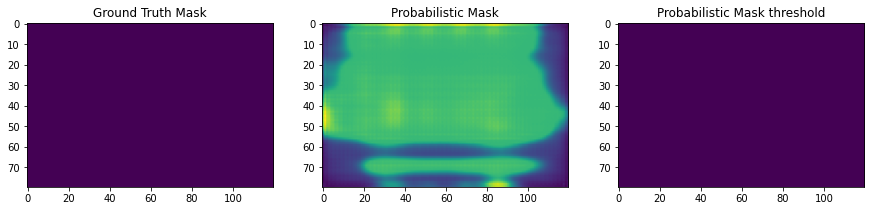

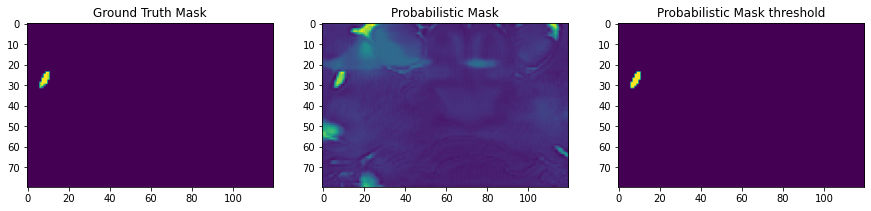

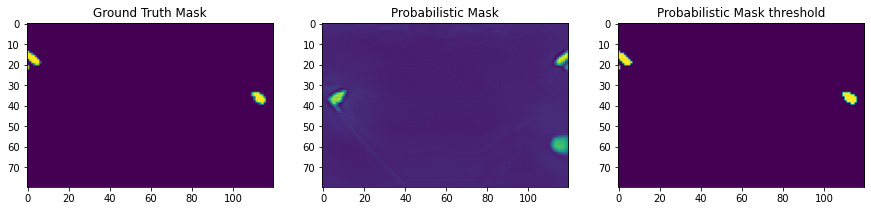

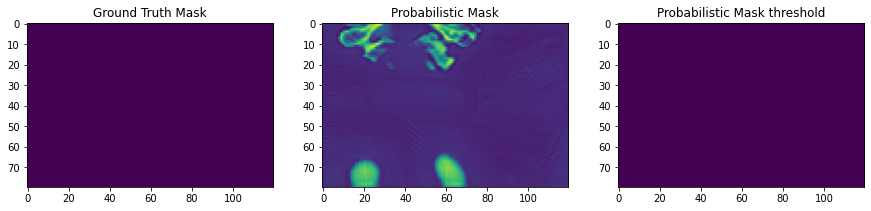

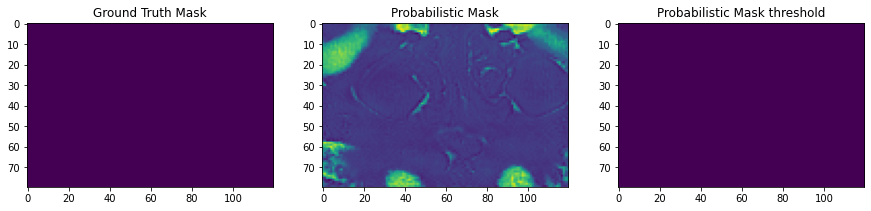

In [28]:
predict(axial_test_loader)

In [29]:
check_accuracy(coronal_test_loader, coronal_model, device=DEVICE)

100%|██████████| 455/455 [01:12<00:00,  6.31it/s]

Dice score: 0.32135024666786194


loss prediction:  0.6597163677215576
loss prediction:  0.7624703049659729
loss prediction:  0.6791484951972961
loss prediction:  0.868170440196991
loss prediction:  0.8687233924865723


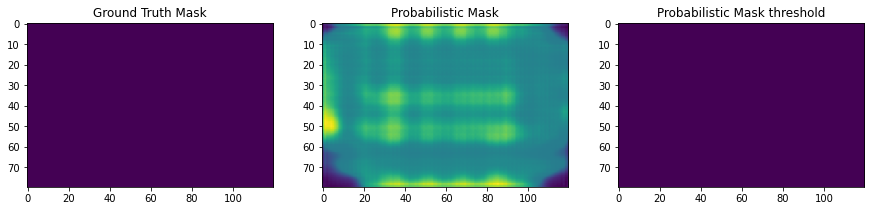

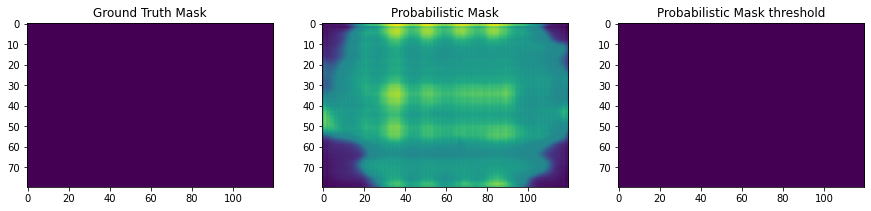

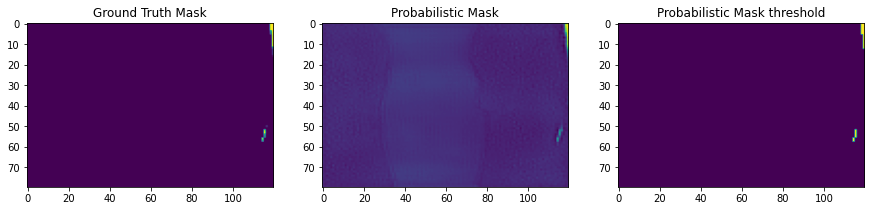

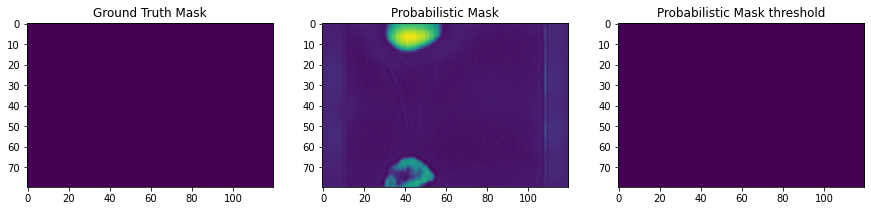

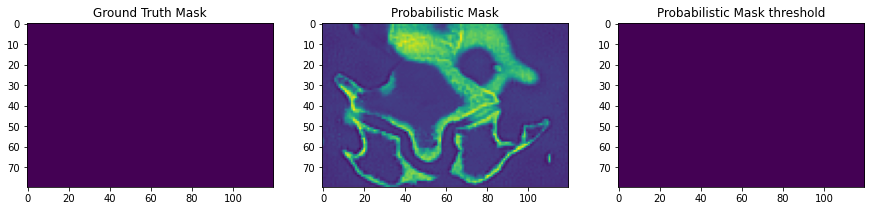

In [30]:
predict(coronal_test_loader)

In [31]:
check_accuracy(sagittal_test_loader, sagittal_model, device=DEVICE)

100%|██████████| 455/455 [01:12<00:00,  6.25it/s]

Dice score: 0.22009670734405518


loss prediction:  0.8266174793243408
loss prediction:  0.7858649492263794
loss prediction:  0.7343931198120117
loss prediction:  0.8139445781707764
loss prediction:  0.869526743888855


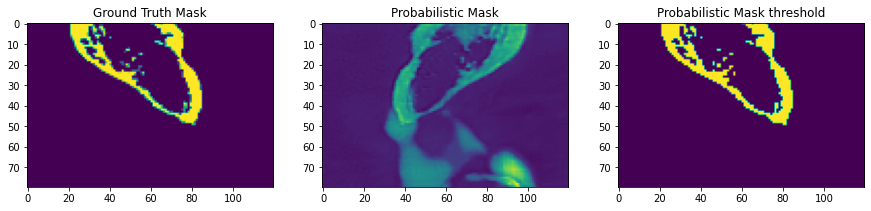

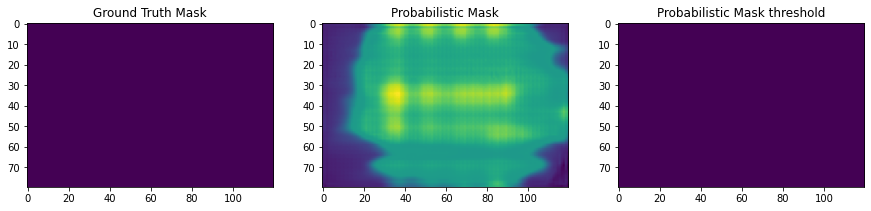

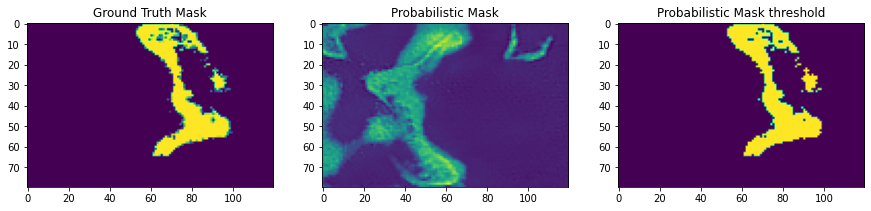

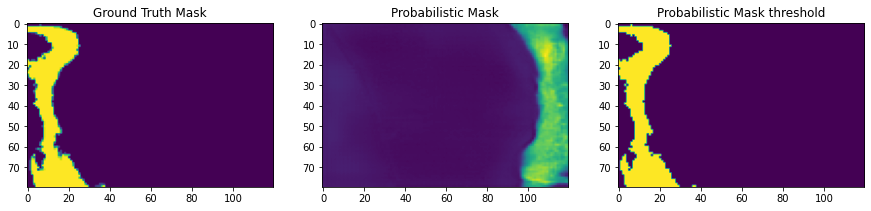

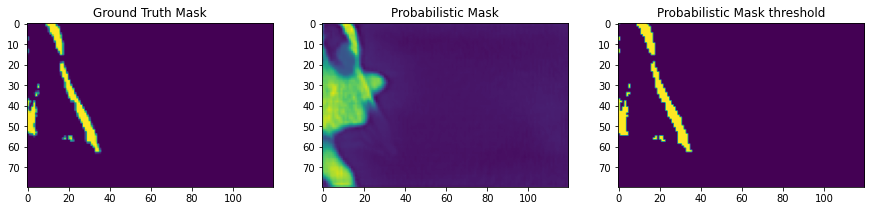

In [32]:
predict(sagittal_test_loader)

## Train one model on the three views

In [33]:
all_train_data = torch.utils.data.ConcatDataset([axial_train_dataset, coronal_train_dataset, sagittal_train_dataset])
all_train_loader = torch.utils.data.DataLoader(all_train_data, shuffle=True, batch_size=BATCH_SIZE)

all_validation_data = torch.utils.data.ConcatDataset([axial_validatiaon_dataset, coronal_validation_dataset, sagittal_validation_dataset])
all_validation_loader = torch.utils.data.DataLoader(all_validation_data, shuffle=True, batch_size=BATCH_SIZE)

In [34]:
model = train_model_2d(all_train_loader, all_validation_loader)

100%|██████████| 137/137 [00:17<00:00,  7.62it/s]


Dice score: 0.26033535599708557


100%|██████████| 137/137 [00:18<00:00,  7.28it/s]


Dice score: 0.30692917108535767


100%|██████████| 137/137 [00:18<00:00,  7.33it/s]


Dice score: 0.28075721859931946


100%|██████████| 137/137 [00:22<00:00,  6.19it/s]


Dice score: 0.34063461422920227


100%|██████████| 137/137 [00:18<00:00,  7.34it/s]


Dice score: 0.3075731098651886


100%|██████████| 137/137 [00:18<00:00,  7.56it/s]


Dice score: 0.38827428221702576


100%|██████████| 137/137 [00:21<00:00,  6.47it/s]


Dice score: 0.45267587900161743


100%|██████████| 137/137 [00:17<00:00,  7.63it/s]


Dice score: 0.4386029541492462


100%|██████████| 137/137 [00:18<00:00,  7.28it/s]


Dice score: 0.39446157217025757


100%|██████████| 137/137 [00:23<00:00,  5.80it/s]

Dice score: 0.4771256744861603


In [35]:
all_test_data = torch.utils.data.ConcatDataset([axial_test_dataset, coronal_test_dataset, sagittal_test_dataset])
all_test_loader = torch.utils.data.DataLoader(all_test_data, shuffle=True, batch_size=BATCH_SIZE)

In [36]:
check_accuracy(all_test_loader, model, device=DEVICE)

100%|██████████| 391/391 [00:50<00:00,  7.68it/s]

Dice score: 0.7331016659736633


loss prediction:  0.629675030708313
loss prediction:  0.6162827610969543
loss prediction:  0.5823699831962585
loss prediction:  0.5247477293014526
loss prediction:  0.5331147313117981


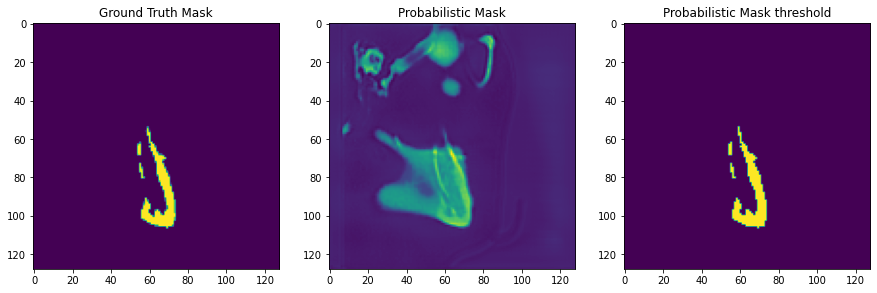

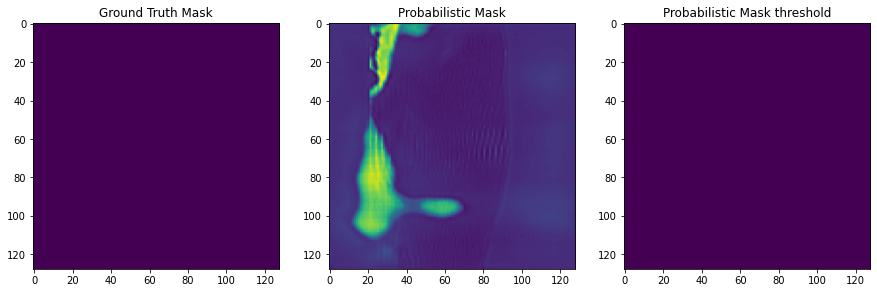

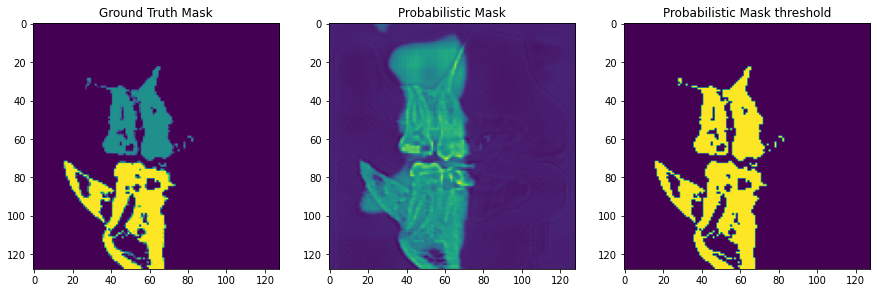

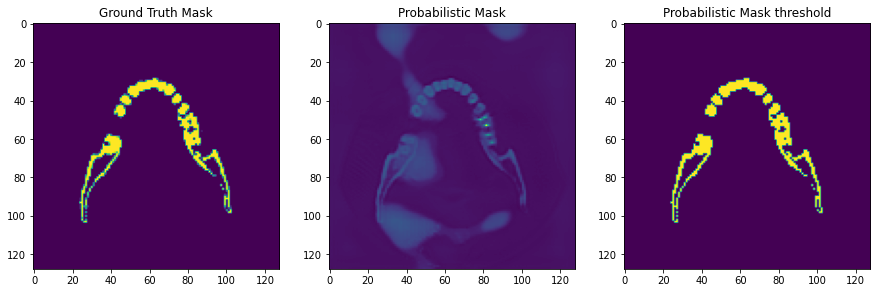

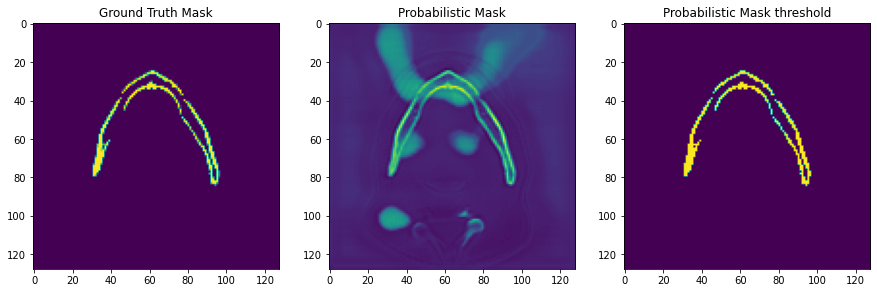

In [37]:
predict(all_test_loader)